In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from scipy.optimize import fsolve
from scipy.integrate import odeint, quad
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

# Main Program

In [2]:
class honolulu(object):
    def __init__(self, a, b, c, n):
        self.n = n
        self.a = a
        self.b = b
        self.c = c
        if c == 0:
            self.s = 1
        else:
            self.s = self.max_U()

    # F(x) = x
    # G(x) = F(x) ^ (n - 1)
    # g(x) = G'(x)
    # H(x) = integral(y[0, x])(G(y))
    # G(v, x) = n * F(v) * F(x) ^ (n - 1)
    # g(v, x) = d^2 G(v, x) / dvdx

    def K(self, pvar, v, s):
        # K(p, v, s) = 2 * b * (H(v) - H(p)) - G(p) * (a - b * (s - v))
        return (
            2 * self.b 
            * (v ** self.n - pvar ** self.n) / self.n 
            - pvar ** (self.n - 1) 
            * (self.a - self.b * (s - v))
        )

    def k(self, v, s):
        # p = k(v, s) solves K(p, v, s) = 0
        K_fun = lambda pvar: self.K(pvar, v, s)
        sol = fsolve(K_fun, v / 2)[0]
        return sol

    def p(self, v, s):
        # p = min{s, k(v, s)}
        return np.minimum(s, self.k(v, s))

    def U(self, s):
        # integral(x[0, p(v, s)], v[0, 1])(p(v, s) * (a - c * (s - p(v, s))) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])(x * (a - c * (s + x - 2 * p(v, s))) * g(v, x)) 
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: (self.n - 1) * v ** self.n * (self.a - self.c * (s - 2 * self.p(v, s)))
            - self.n * (self.n - 1) / (self.n + 1) * self.c * v ** (self.n + 1)
            + self.p(v, s) ** self.n * (self.a - self.c * s + 2 * self.c * self.p(v, s) / (self.n + 1))
        )
        sol = quad(integrand, 0, 1)[0]
        return sol

    def max_U(self):
        obj_fun = lambda s: - self.U(s)
        sol = minimize_scalar(obj_fun, bounds=(0, 1), method="bounded")
        return sol["x"]
    
    def EUa(self):
        return self.U(self.s)

    def ER(self):
        # integral(x[0, p(v, s)], v[0, 1])(p(v, s) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])(x * g(v, x))
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: self.p(v, self.s) ** self.n
            + (self.n - 1) * v ** self.n
        )
        sol = quad(integrand, 0, 1)[0]
        return sol

    def ED(self):
        # integral(x[0, p(v, s)], v[0, 1])((s - p(v, s)) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])((s + x - 2 * p(v, s)) * g(v, x))
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: self.p(v, self.s) ** self.n
            + (self.n - 1) * v ** self.n
            + self.n * (self.s - 2 * self.p(v, self.s)) * v ** (self.n - 1)
        )
        sol = quad(integrand, 0, 1)[0]
        return sol
    
    def eUb(self, v):
        # G(p(v, s)) * (v - p(v, s)) * (a - b * (s - p(v, s))) +
        # integral(x[p(v, s), v])((v - x) * (a -  b * (s + x - 2 * p(v, s))) * g(x))
        integrand = (
            lambda x: (v - x)
            * (self.a - self.b * (self.s + x - 2 * self.p(v, self.s)))
            * (self.n - 1) * x ** (self.n - 2)
        )
        return (
            self.p(v, self.s) ** (self.n - 1)
            * (v - self.p(v, self.s))
            * (self.a - self.b * (self.s - self.p(v, self.s)))
            + quad(integrand, self.p(v, self.s), v)[0]
        )

    def EUb(self):
        integrand = lambda v: self.eUb(v)
        return quad(integrand, 0, 1)[0]

    def ePb(self, v):
        # p(v, s) ^ n + integral(x[p(v, s), v])(x * g(x))
        integrand = lambda x: x * (self.n - 1) * x ** (self.n - 2)
        return self.p(v, self.s) ** self.n + quad(integrand, self.p(v, self.s), v)[0]

In [3]:
class dutch(object):
    def __init__(self, a, b, c, n):
        self.a = a
        self.b = b
        self.c = c
        self.n = n
        self.vs = np.linspace(1e-16, 1, 1000)

    # F(x) = x
    # G(x) = F(x) ^ (n - 1)
    # g(x) = G'(x)
    # H(x) = F(x) ^ n
    # h(x) = H'(x)

    def db_dv(self, beta, v):
        # beta'(v) = g(v)* (v - beta(v)) * (a - b * (1 - beta(v))) / (G(v) * (a + 2 * b * beta(v) - b - b * v))
        return (
            (self.n - 1) * v ** (self.n - 2)
            * (v - beta)
            * (self.a - self.b * (1 - beta))
            / (v ** (self.n - 1) * (self.a + 2 * self.b * beta - self.b - self.b * v))
        )

    def solve_ode(self):
        beta0 = 0
        return odeint(self.db_dv, beta0, self.vs).flatten()

    def beta(self, v):
        return interp1d(self.vs, self.solve_ode(), fill_value="extrapolate")(v)

    def EUa(self):
        # integral(v[0, 1])(beta(v) * (a - c * (1 - beta(v))) * h(v))
        integrand = (
            lambda v: self.beta(v)
            * (self.a - self.c * (1 - self.beta(v)))
            * self.n * v ** (self.n - 1)
        )
        return quad(integrand, 0, 1)[0]

    def ER(self):
        # integral(v[0, 1])(beta(v) * h(v))
        integrand = lambda x: self.beta(x) * self.n * x ** (self.n - 1)
        return quad(integrand, 0, 1)[0]
    
    def ED(self):
        # 1- integral(v[0, 1])(beta(v) * h(v))
        integrand = lambda v: self.beta(v) * self.n * v ** (self.n - 1)
        return 1 - quad(integrand, 0, 1)[0]

    def eUb(self, v):
        # v ^ (n - 1) * (v - beta(v)) * (a - b * (1 - beta(v)))
        return (
            v ** (self.n - 1) * (v - self.beta(v)) * (self.a - self.b * (1 - self.beta(v)))
        )
    
    def EUb(self):
        integrand = lambda v: self.eUb(v)
        return quad(integrand, 0, 1)[0]

    def ePb(self, v):
        # v ^ (n - 1) * beta(v)
        return v ** (self.n - 1) * self.beta(v)

# Computation

In [4]:
def dutchRevenueComparison(list_n, eval_n, eval_interval):
    #array_EUa = np.zeros((eval_n + 1, eval_n + 1))
    #array_ER = np.zeros((eval_n + 1, eval_n + 1))
    #array_ED = np.zeros((eval_n + 1, eval_n + 1))
    array_EUb = np.zeros((eval_n + 1, eval_n + 1))
    for n in list_n:
        print("Processing n=%d: " % n, end="")
        for ib in range(eval_n + 1):
            for ic in range(eval_n + 1):
                da = dutch(1, ib * eval_interval, ic * eval_interval, n)
                #array_EUa[ib][ic] = da.EUa()
                #array_ER[ib][ic] = da.ER()
                #array_ED[ib][ic] = da.ED()
                array_EUb[ib][ic] = da.EUb()
            print("%d " % ib, end="")
        #np.savetxt(str(n) + "_da_EUa.csv", array_EUa, delimiter=",")
        #np.savetxt(str(n) + "_da_ER.csv", array_ER, delimiter=",")
        #np.savetxt(str(n) + "_da_ED.csv", array_ED, delimiter=",")
        np.savetxt(str(n) + "_da_EUb.csv", array_EUb, delimiter=",")
        print("Finished.") 

In [ ]:
dutchRevenueComparison([2, 3, 4, 5, 6], 50, 0.02)

In [ ]:
def honoluluRevenueComparison(list_n, eval_n, eval_interval):
    array_EUa = np.zeros((eval_n + 1, eval_n + 1))
    array_ER = np.zeros((eval_n + 1, eval_n + 1))
    array_ED = np.zeros((eval_n + 1, eval_n + 1))
    array_EUb = np.zeros((eval_n + 1, eval_n + 1))
    for n in list_n:
        print("Processing n=%d: " % n, end="")
        for ib in range(eval_n + 1):
            for ic in range(eval_n + 1):
                ha = honolulu(1, ib * eval_interval, ic * eval_interval, n)
                array_EUa[ib][ic] = ha.EUa()
                array_ER[ib][ic] = ha.ER()
                array_ED[ib][ic] = ha.ED()
                array_EUb[ib][ic] = ha.EUb()
            print("%d " % ib, end="")
        np.savetxt(str(n) + "_ha_EUa.csv", array_EUa, delimiter=",")
        np.savetxt(str(n) + "_ha_ER.csv", array_ER, delimiter=",")
        np.savetxt(str(n) + "_ha_ED.csv", array_ED, delimiter=",")
        np.savetxt(str(n) + "_ha_EUb.csv", array_EUb, delimiter=",")
        print("Finished.") 

In [ ]:
honoluluRevenueComparison([2, 3, 4, 5, 6], 50, 0.02)

# Absolute difference

In [ ]:
def graphHeatmap(n, eval_n, eval_interval, type):
    ha_list = pd.read_csv(str(n) + "_ha_" + type + ".csv", header=None).values
    da_list = pd.read_csv(str(n) + "_da_" + type + ".csv", header=None).values
    diff_list = ha_list - da_list
    plt.figure(figsize=(12, 10), facecolor="white")
    ax = sns.heatmap(
        diff_list,
        linewidths=0.5,
        vmin=-0.003,
        vmax=0.003,
        center=0,
        cmap=sns.color_palette("vlag_r", as_cmap=True),
        cbar_kws={
            "label": "$HA-DA$",
            "ticks": [-1, -0.002, -0.001, 0, 0.001, 0.002, 1],
        },
        square=True,
    )
    tick_num = 6
    ax.set_xticks(np.linspace(0, eval_n, tick_num))
    ax.set_xticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
    ax.set_yticks(np.linspace(0, eval_n, tick_num))
    ax.set_yticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
    ax.set(xlabel="c", ylabel="b")
    plt.title(type + " differences for n=" + str(n))


In [ ]:
graphHeatmap(2, 50, 0.02, "EUa")

# Relative difference

In [6]:
type = "ED"
i = 2
ha_list = pd.read_csv(str(i) + "_ha_" + type + ".csv", header=None).values[1:50, 1:50]
da_list = pd.read_csv(str(i) + "_da_" + type + ".csv", header=None).values[1:50, 1:50]
diff_list = (ha_list - da_list) * 100 / da_list

In [7]:
def graphPctHeatmap(eval_n, eval_interval, type):
    fig, axn = plt.subplots(1, 2, figsize=(15, 5), dpi=200, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.495, 0.15, 0.01, 0.7], frame_on=False)
    if type == "EUa":
        min_diff = -25
        max_diff = 55
    elif type == "ER":
        min_diff = -10
        max_diff = 3
    elif type == "ED":
        min_diff = -60
        max_diff = 80
    elif type == "EUb":
        min_diff = -25
        max_diff = 105
    fig.colorbar(ScalarMappable(norm=mcolors.TwoSlopeNorm(0, min_diff, max_diff), cmap="vlag_r"), cax=cbar_ax, format="%.0f%%", orientation="vertical")

    for ix, ax in enumerate(axn.flat):
        if ix == 0:
            i = 2
        elif ix == 1:
            i = 5
        ha_list = pd.read_csv(str(i) + "_ha_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
        da_list = pd.read_csv(str(i) + "_da_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
        diff_list = (ha_list - da_list) * 100 / da_list
        sns.heatmap(
            diff_list,
            ax=ax,
            linewidths=0.5,
            cmap=sns.color_palette("vlag_r", as_cmap=True),
            norm =mcolors.TwoSlopeNorm(0, min_diff, max_diff),
            # cbar_kws={
            #     "label": "$\\frac{HA-DA}{DA}$",
            #     "ticks": [-20, -10, 0, 10, 20, 30, 40, 50],
            #     "format": "%.0f%%",
            # },
            cbar=False,
            square=True,
        )
        tick_num = 6
        ax.set_xticks(np.linspace(0, eval_n, tick_num))
        ax.set_xticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
        ax.set_yticks(np.linspace(0, eval_n, tick_num))
        ax.set_yticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
        ax.set(xlabel="c — auctioneer time cost", ylabel="b — bidder time cost")
        ax.set_title(str(i) + " bidders")
        ax.invert_yaxis()
        custom_lines = [
            Line2D([0], [0], color=sns.cm.vlag_r(1.0), lw=4),
            Line2D([0], [0], color=sns.cm.vlag_r(0.0), lw=4)
        ]
        ax.legend(custom_lines, ["HA higher", "DA higher"], loc="upper center")

        ax.scatter([47.5], [47.5], color="black", marker="o", facecolors="none", s=100)
        ax.annotate(str(i) + "H", (47.5, 47.5), (50.5, 45), arrowprops=dict(arrowstyle="-"), fontsize=12)
        ax.scatter([47.5], [22.5], color="black", marker="o", facecolors="none", s=100)
        ax.annotate(str(i) + "L", (47.5, 22.5), (50.5, 20), arrowprops=dict(arrowstyle="-"), fontsize=12)

    
    

In [8]:
def graphPctHeatmap2(eval_n, eval_interval, type):
    fig, axn = plt.subplots(2, 2, figsize=(15, 16), dpi=200, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.01], frame_on=False)
    if type == "EUa":
        min_diff = -25
        max_diff = 55
    elif type == "ER":
        min_diff = -10
        max_diff = 3
    elif type == "ED":
        min_diff = -60
        max_diff = 80
    elif type == "EUb":
        min_diff = -25
        max_diff = 105
    fig.colorbar(ScalarMappable(norm=mcolors.TwoSlopeNorm(0, min_diff, max_diff), cmap="vlag_r"), cax=cbar_ax, format="%.0f%%", orientation="horizontal")
    
    for ix, ax in enumerate(axn.flat):
        i = ix + 2
        ha_list = pd.read_csv(str(i) + "_ha_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
        da_list = pd.read_csv(str(i) + "_da_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
        diff_list = (ha_list - da_list) * 100 / da_list
        sns.heatmap(
            diff_list,
            ax=ax,
            linewidths=0.5,
            cmap=sns.color_palette("vlag_r", as_cmap=True),
            norm =mcolors.TwoSlopeNorm(0, min_diff, max_diff),
            # cbar_kws={
            #     "label": "$\\frac{HA-DA}{DA}$",
            #     "ticks": [-20, -10, 0, 10, 20, 30, 40, 50],
            #     "format": "%.0f%%",
            # },
            cbar=False,
            square=True,
        )
        tick_num = 6
        ax.set_xticks(np.linspace(0, eval_n, tick_num))
        ax.set_xticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
        ax.set_yticks(np.linspace(0, eval_n, tick_num))
        ax.set_yticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
        ax.set(xlabel="c — auctioneer time cost", ylabel="b — bidder time cost")
        ax.set_title(str(i) + " bidders")
        ax.invert_yaxis()
        custom_lines = [
            Line2D([0], [0], color=sns.cm.vlag_r(1.0), lw=4),
            Line2D([0], [0], color=sns.cm.vlag_r(0.0), lw=4)
        ]
        ax.legend(custom_lines, ["HA higher", "DA higher"], loc="upper center")

        # ax.scatter([47.5], [47.5], color="black", marker="o", facecolors="none", s=100)
        # ax.annotate(str(i) + "H", (47.5, 47.5), (50.5, 45), arrowprops=dict(arrowstyle="-"), fontsize=12)
        # ax.scatter([47.5], [22.5], color="black", marker="o", facecolors="none", s=100)
        # ax.annotate(str(i) + "L", (47.5, 22.5), (50.5, 20), arrowprops=dict(arrowstyle="-"), fontsize=12)

    

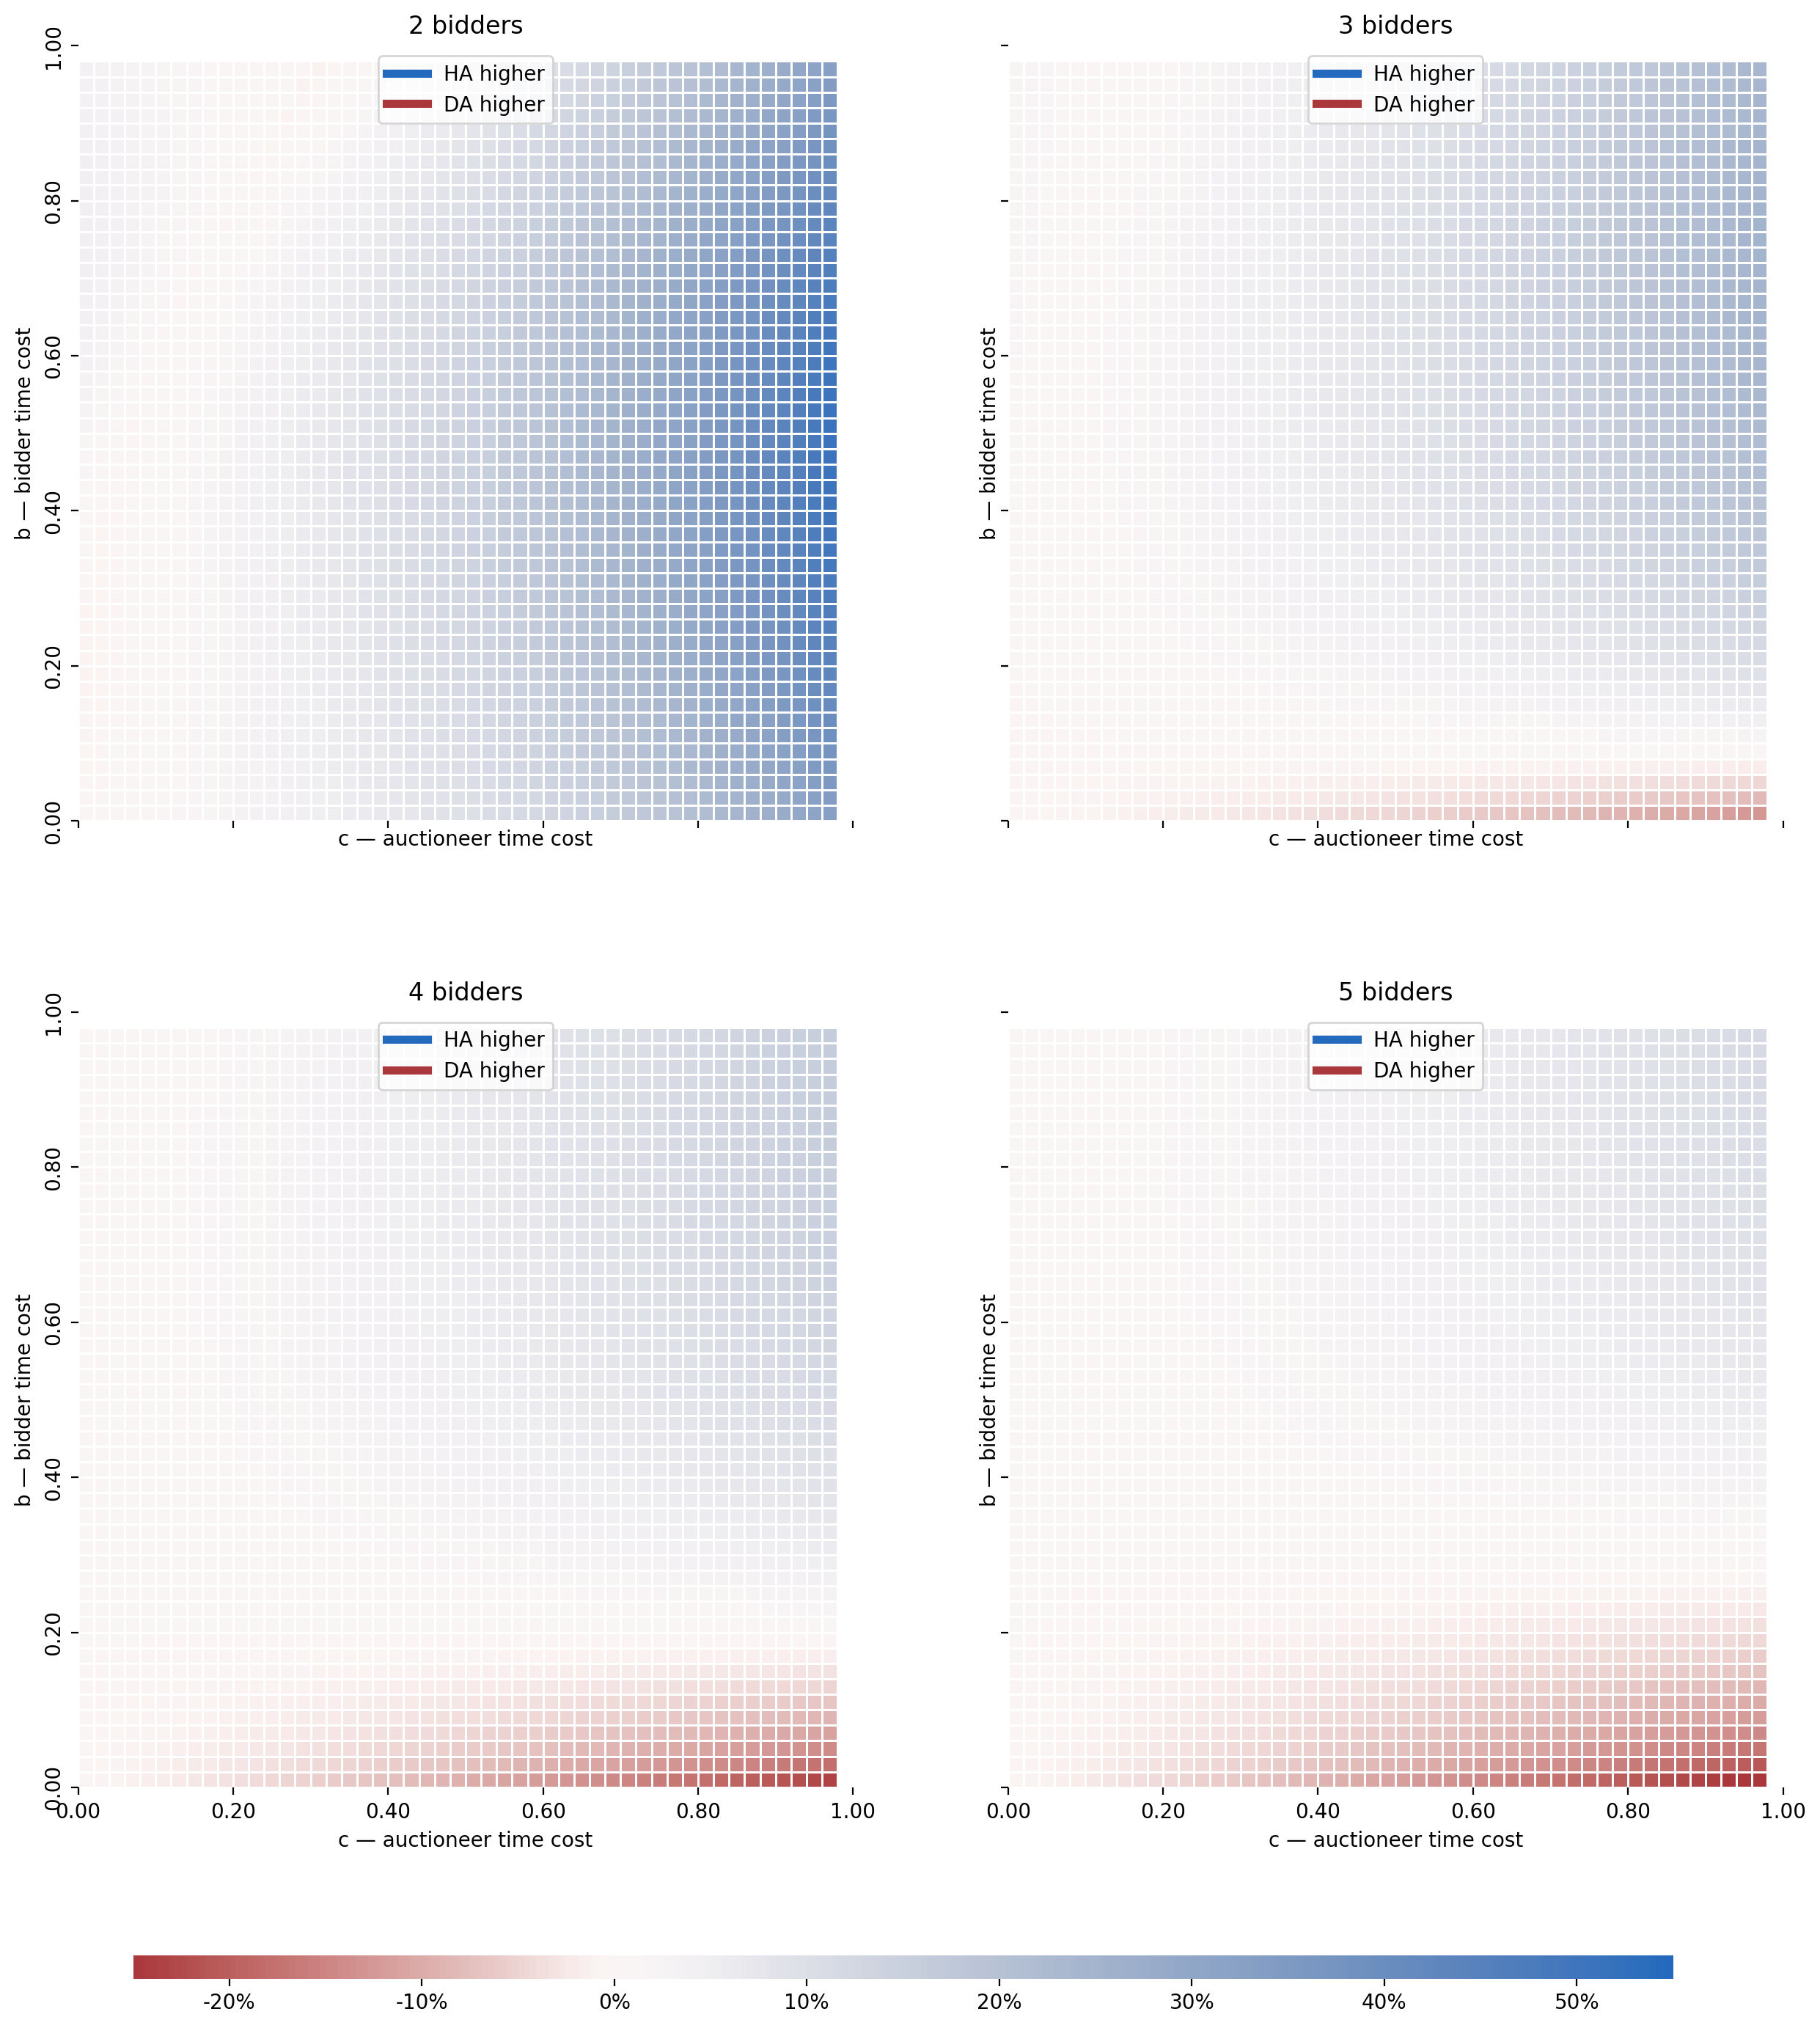

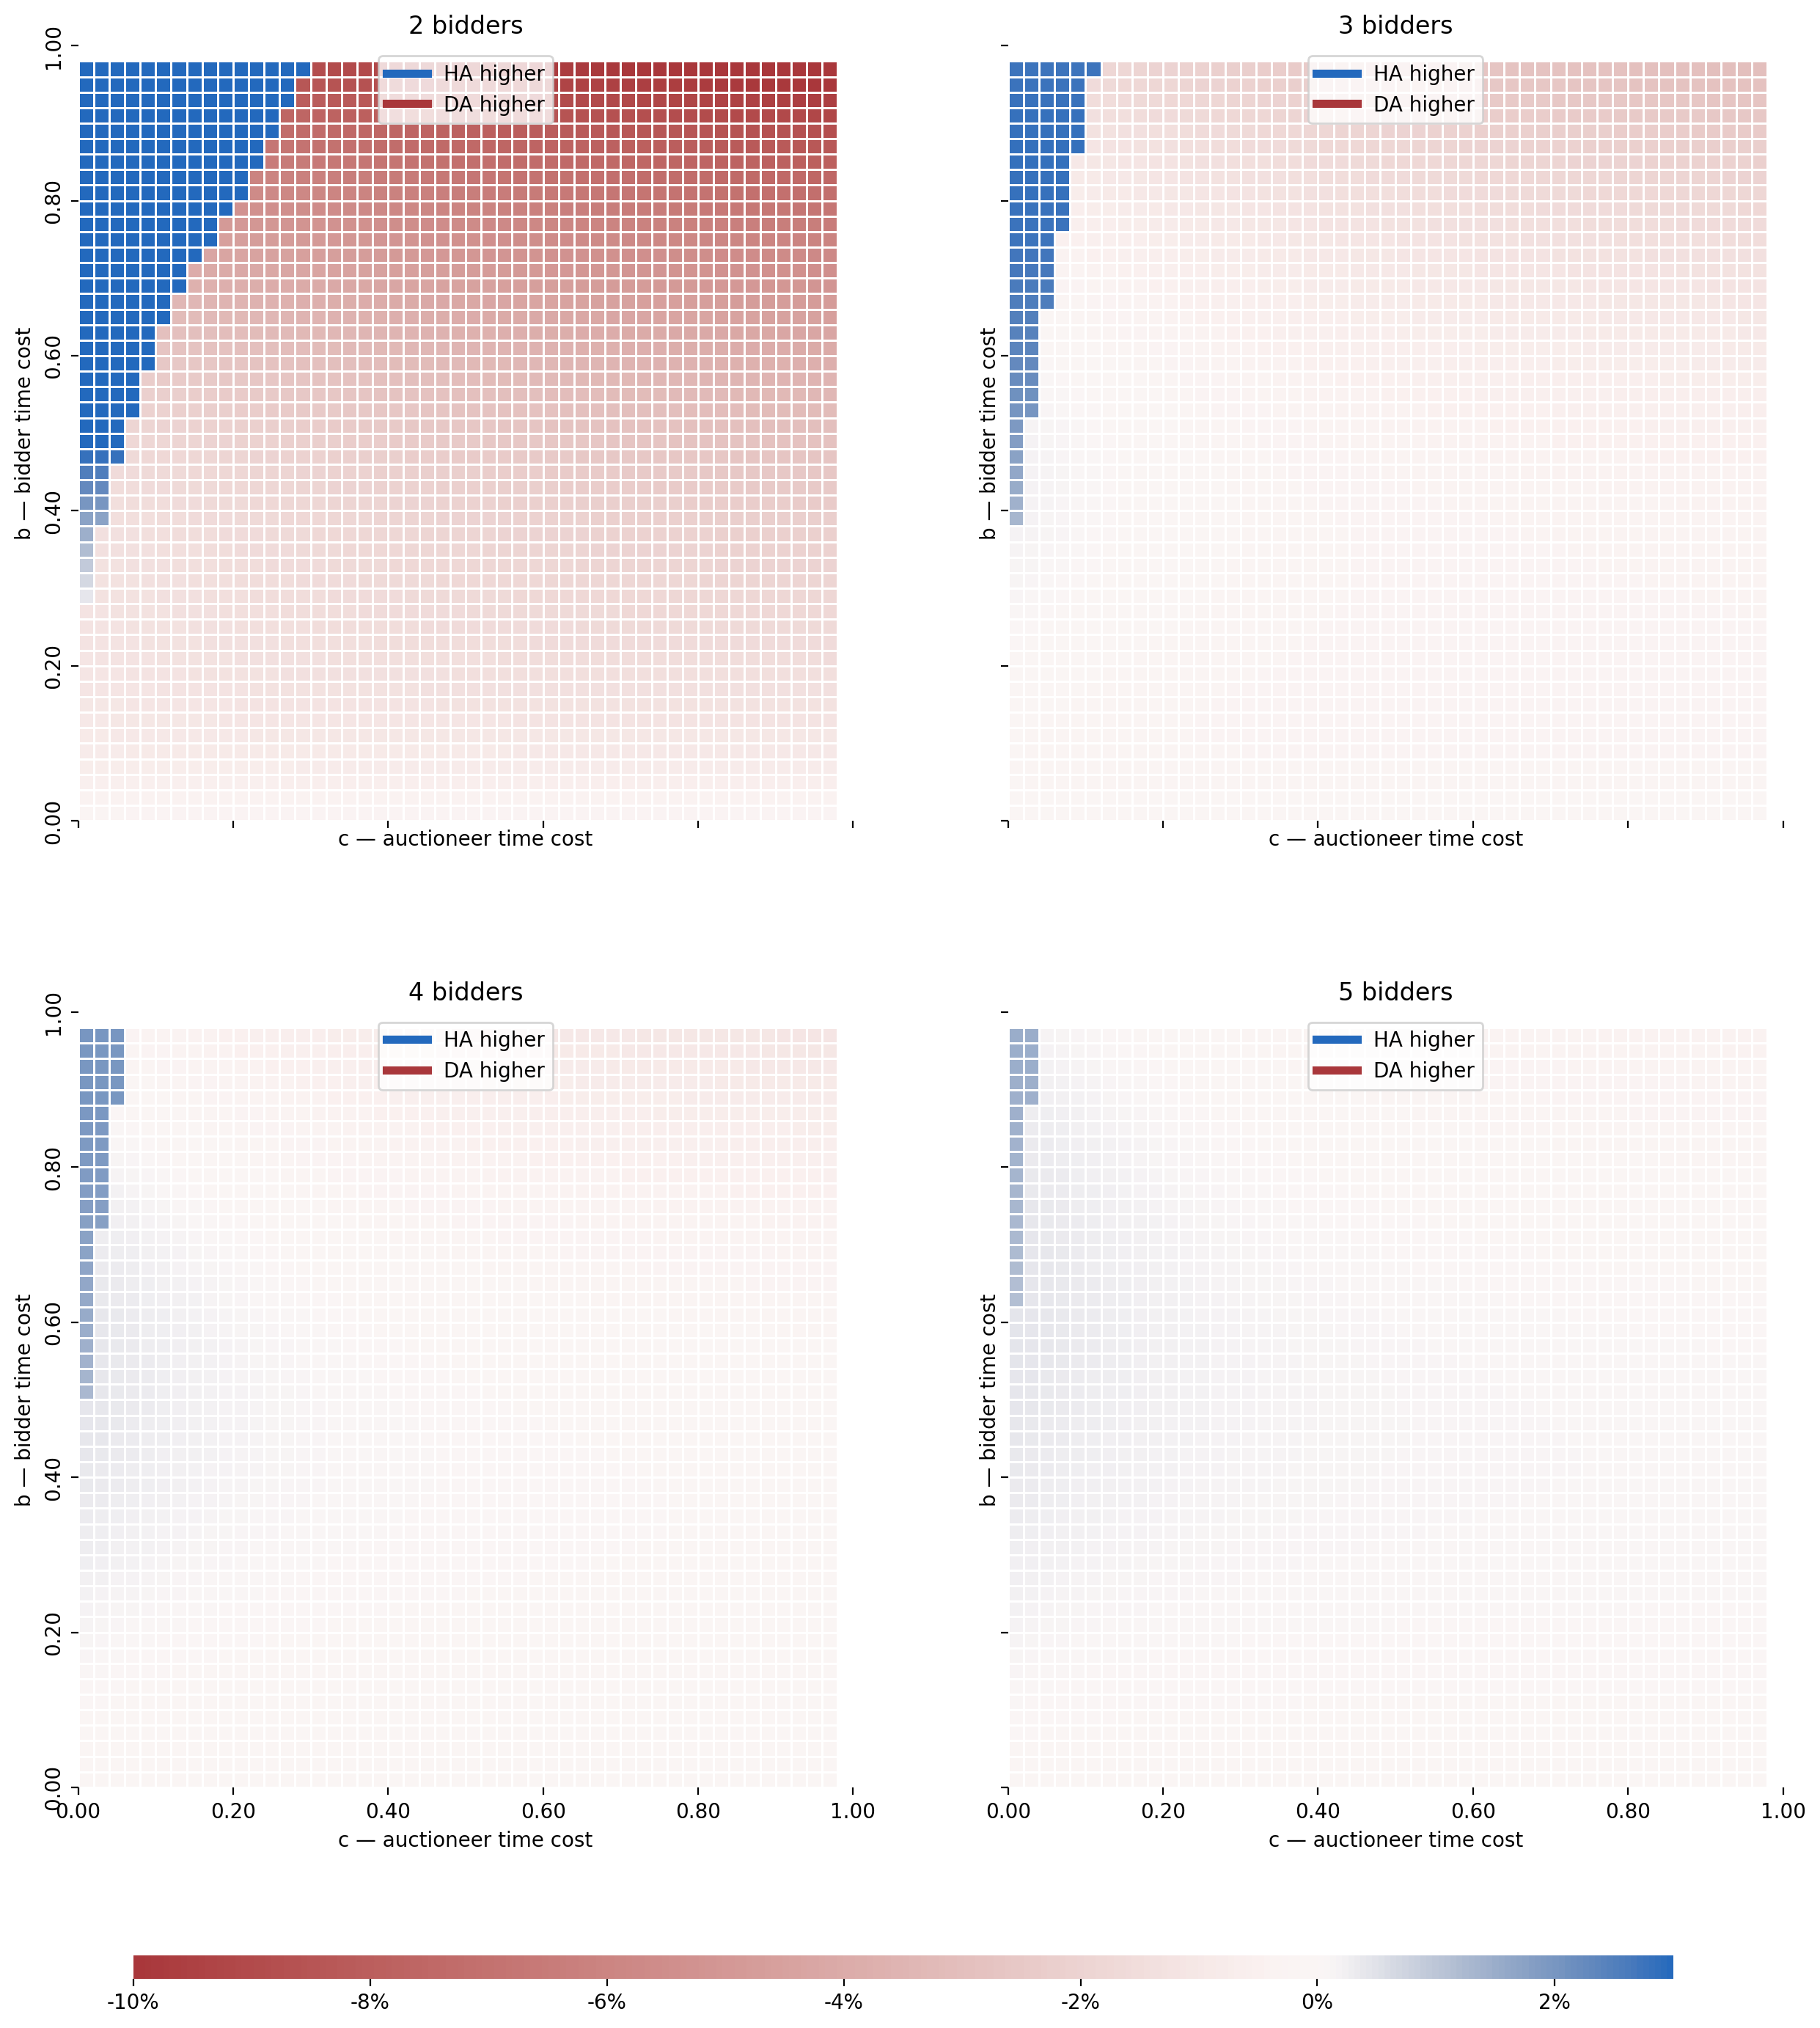

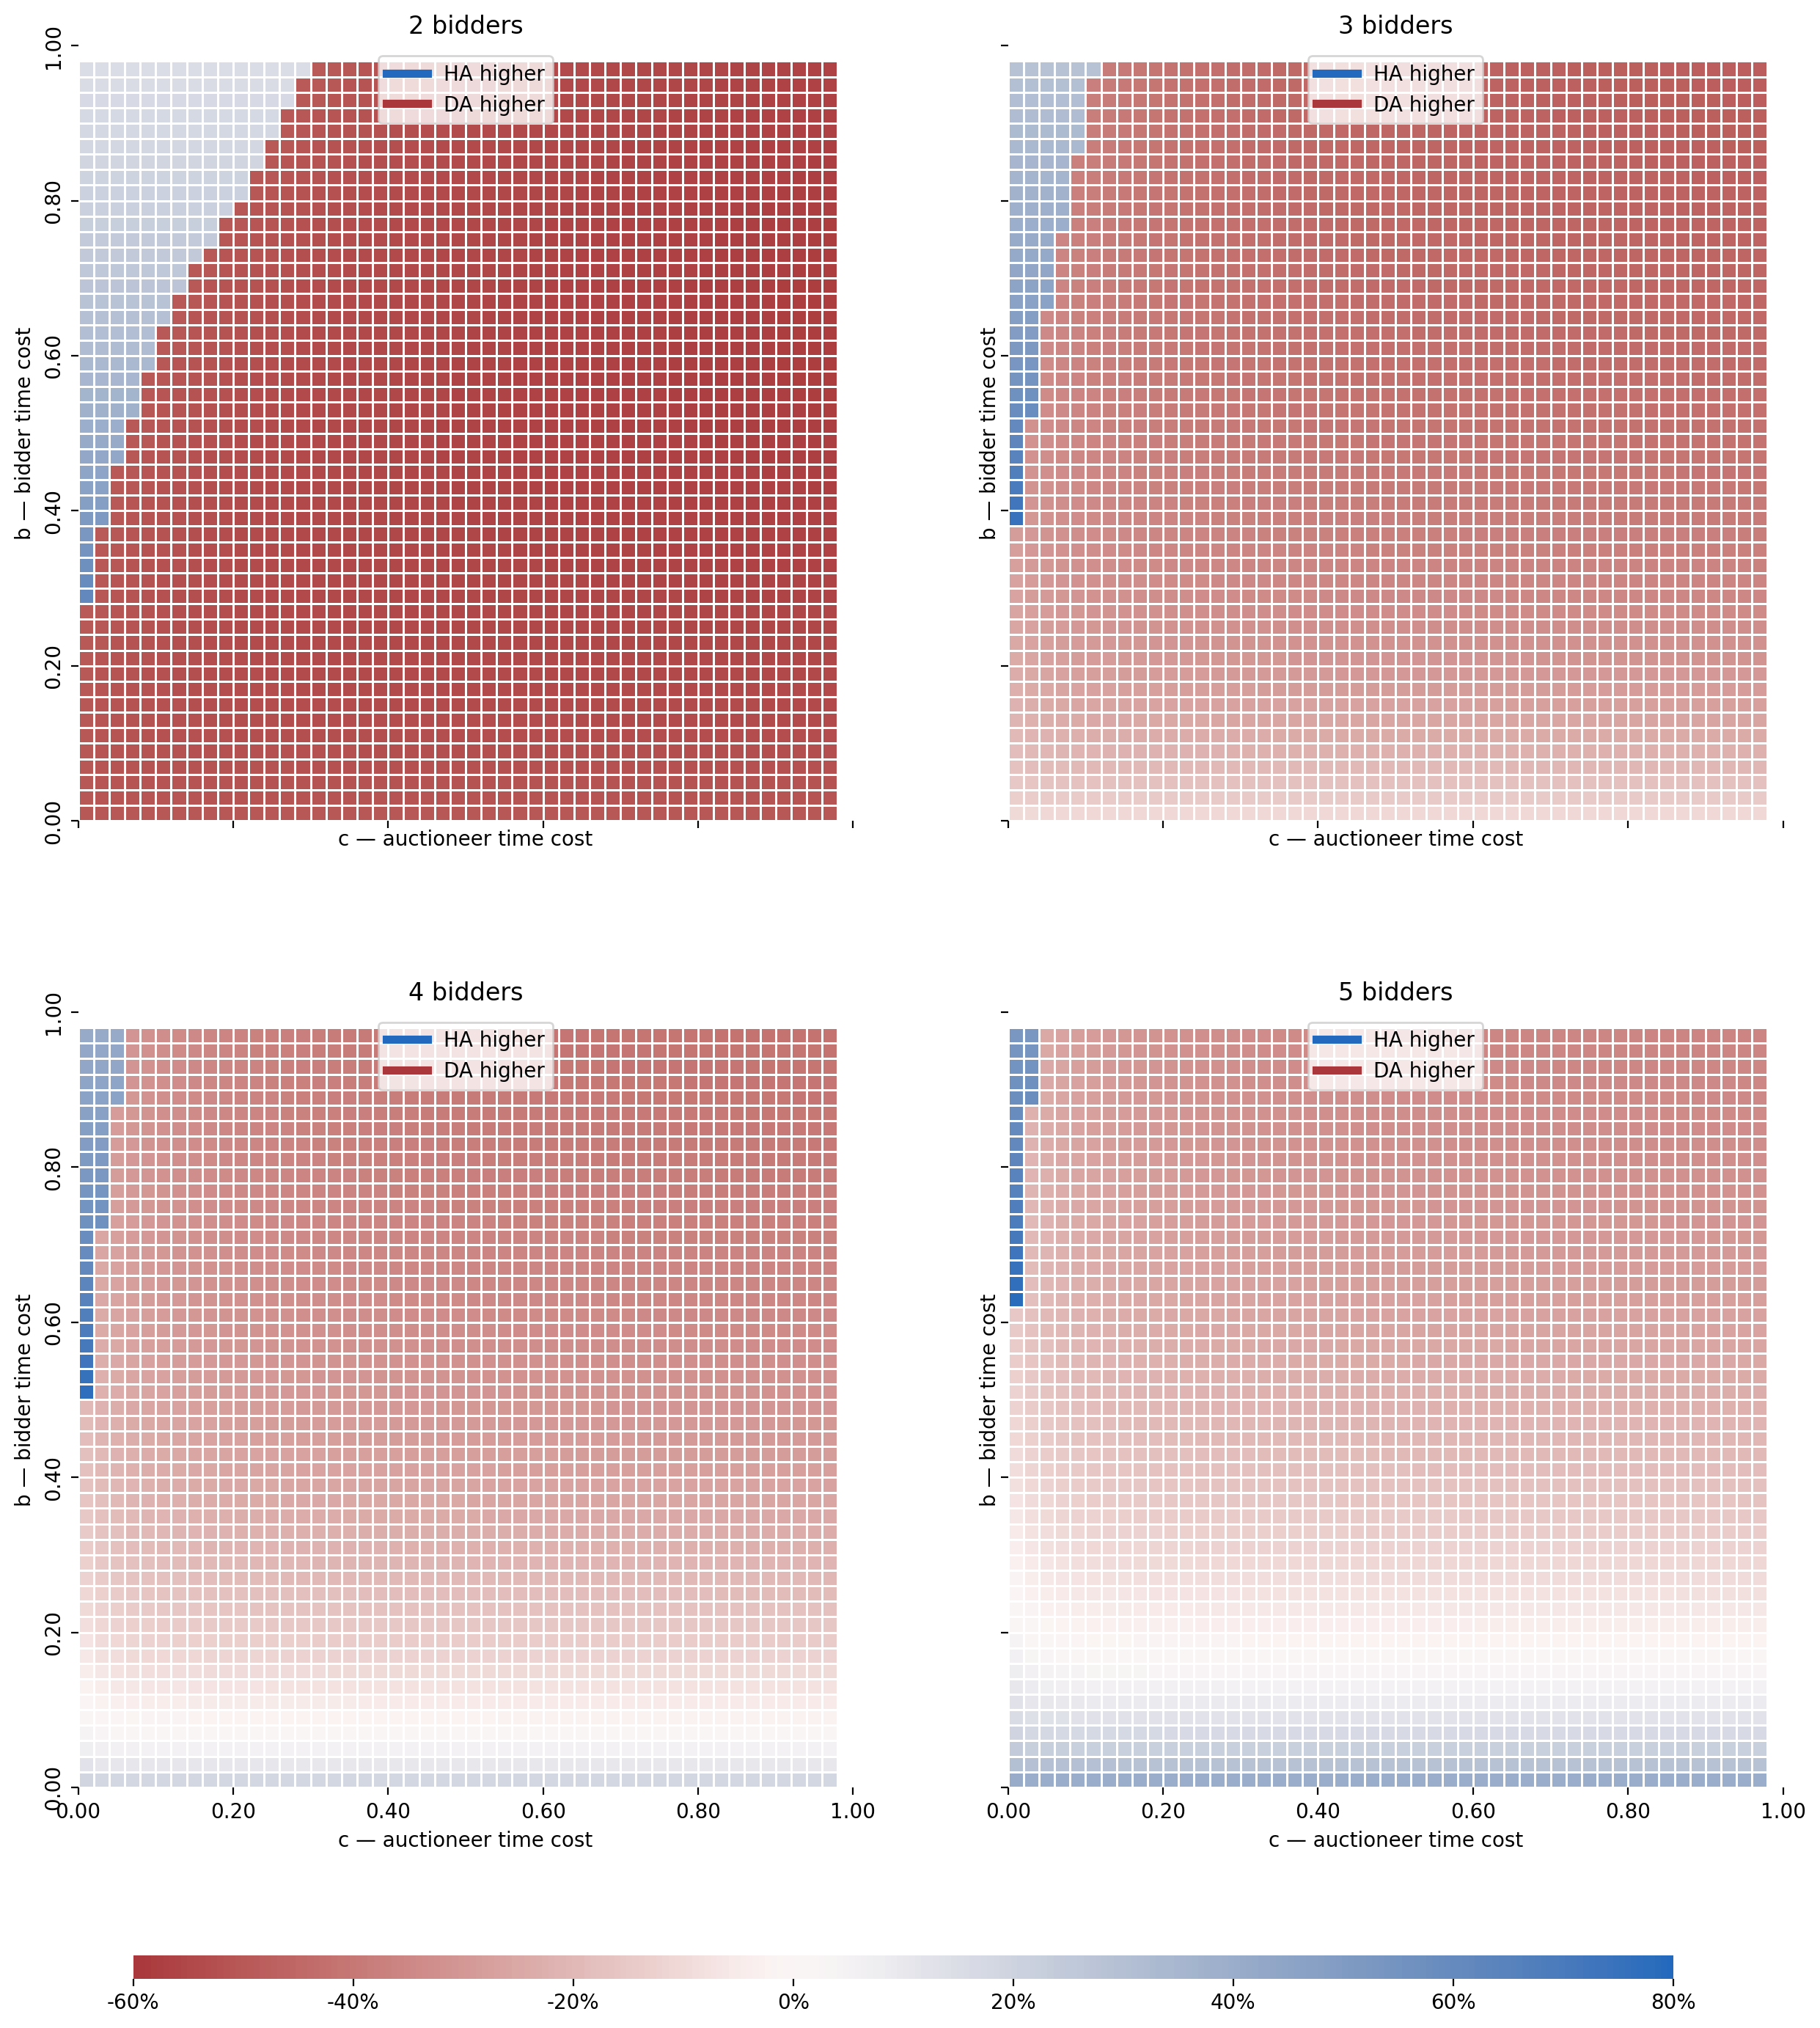

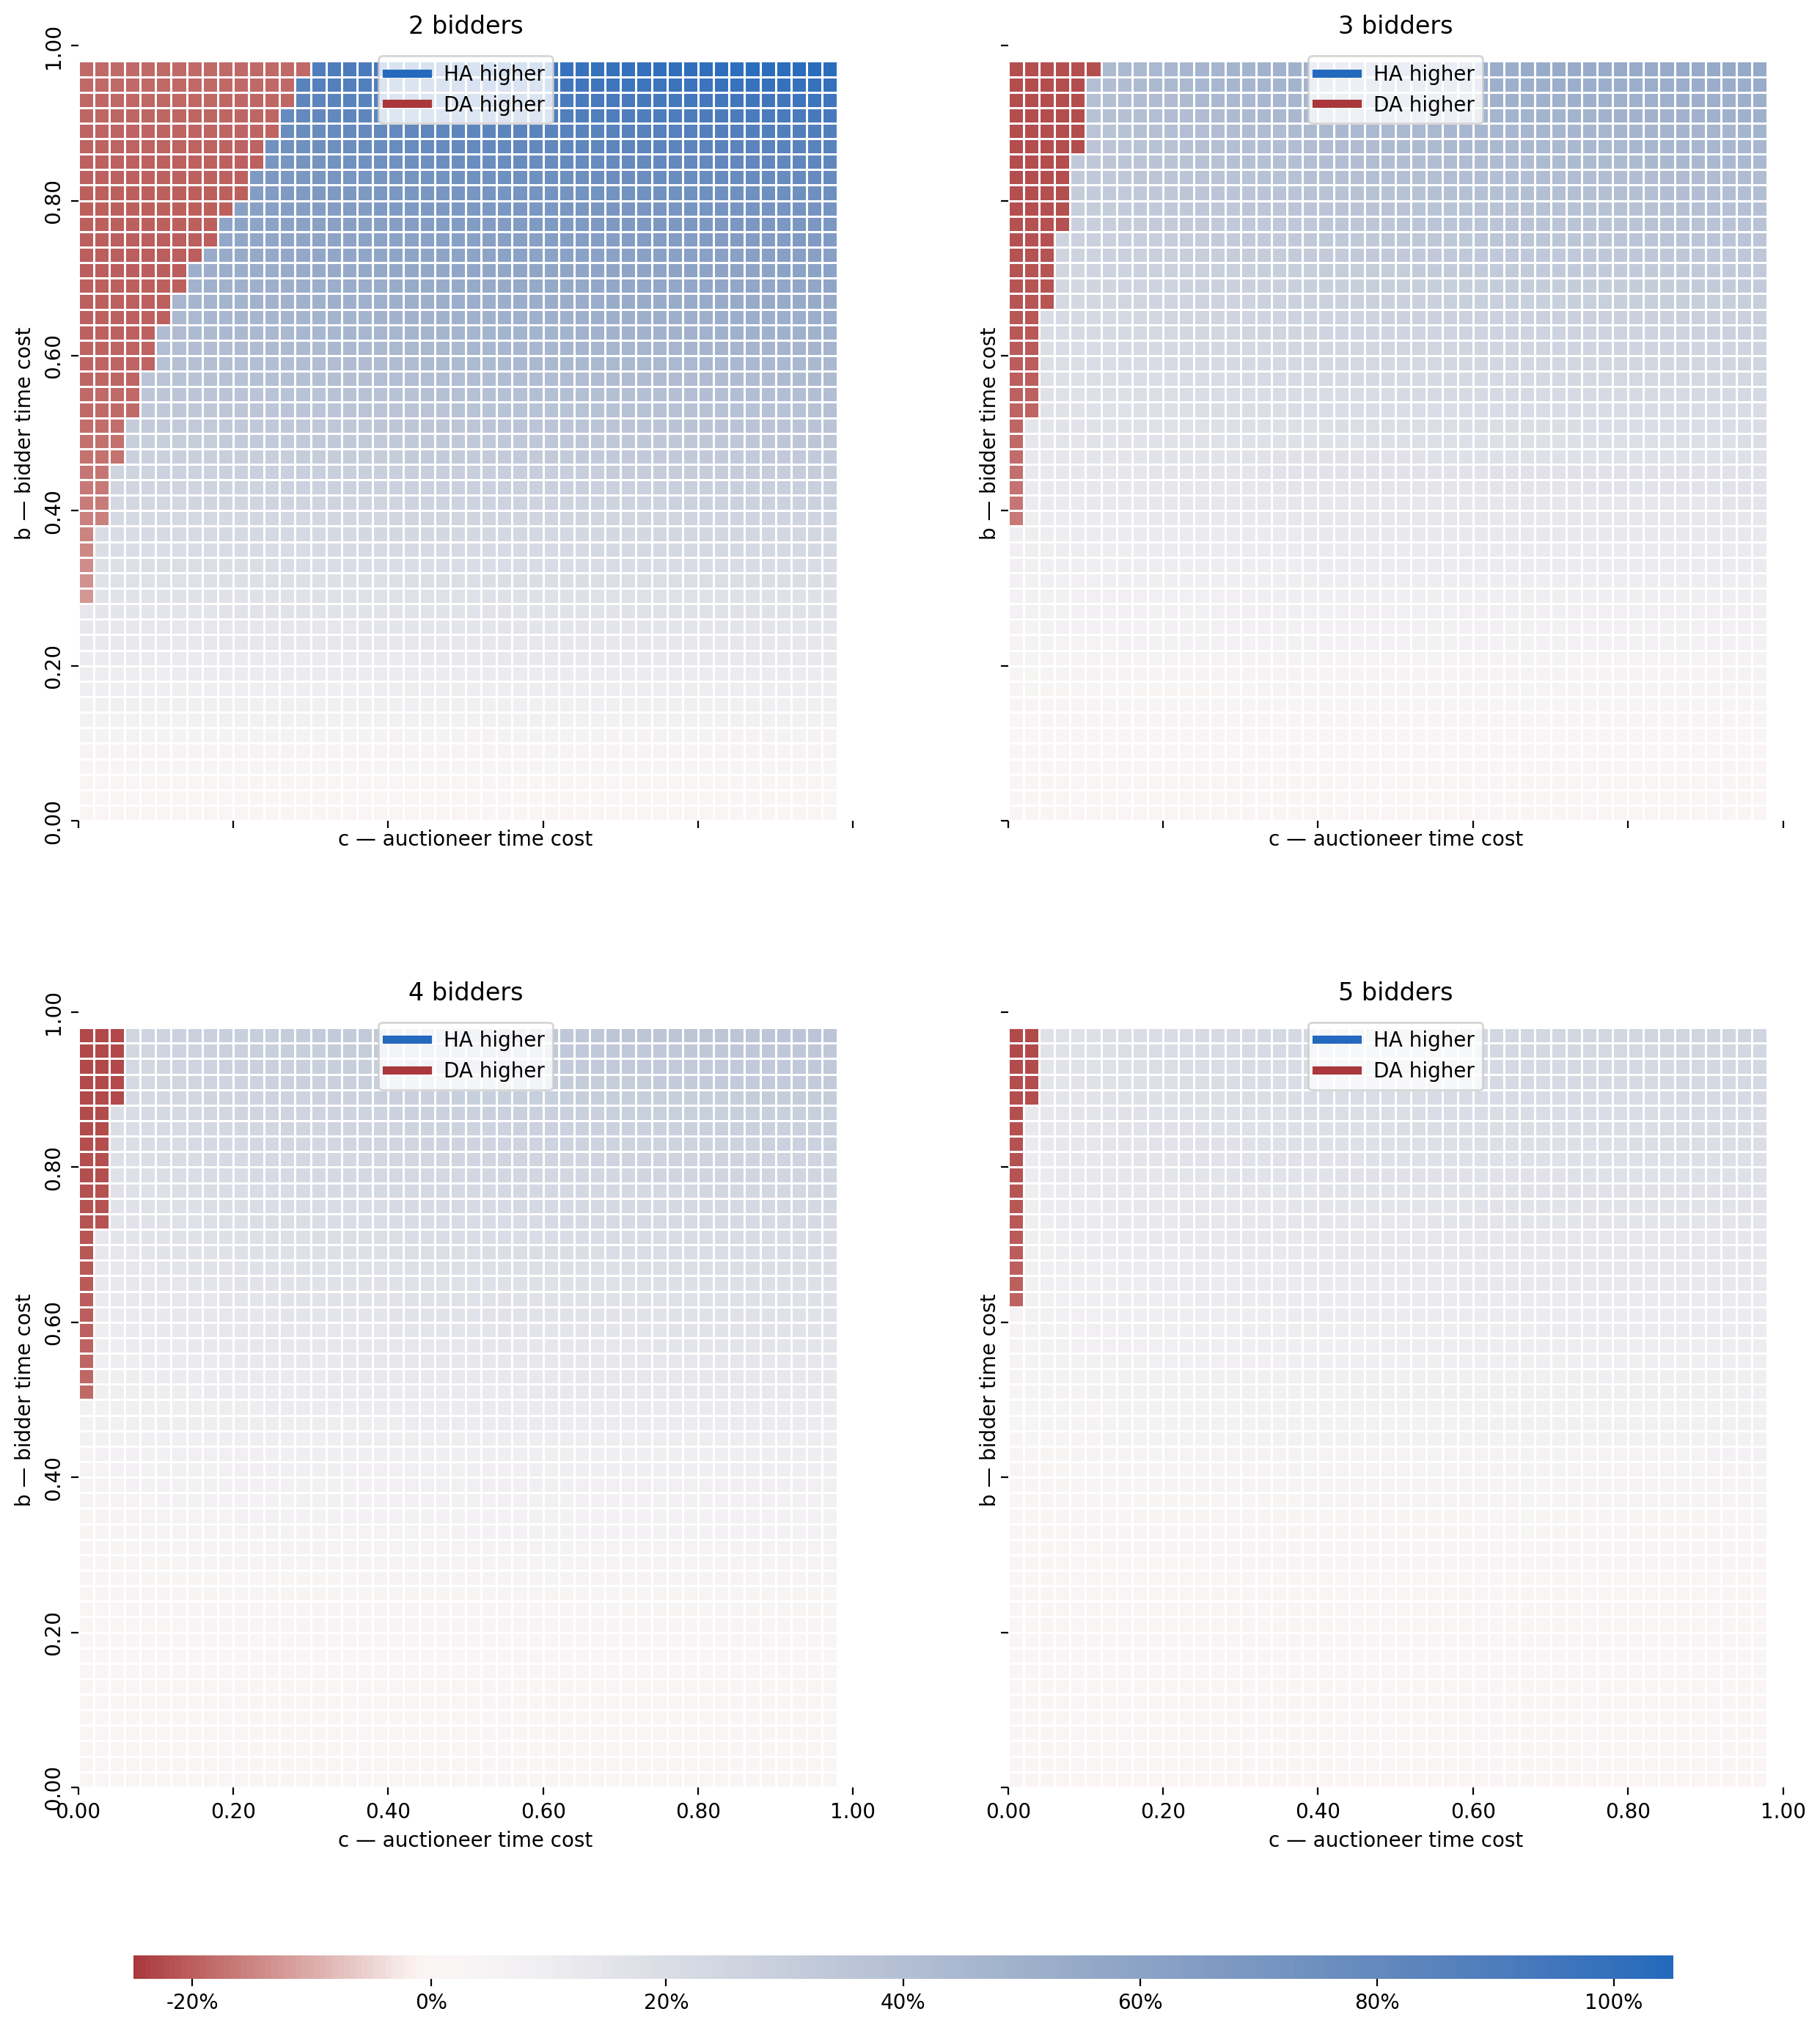

In [9]:
graphPctHeatmap2(50, 0.02, "EUa")
graphPctHeatmap2(50, 0.02, "ER")
graphPctHeatmap2(50, 0.02, "ED")
graphPctHeatmap2(50, 0.02, "EUb")

## Backup codes

In [60]:
def graphPctHeatmap(n, eval_n, eval_interval, type):
    ha_list = pd.read_csv(str(n) + "_ha_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
    da_list = pd.read_csv(str(n) + "_da_" + type + ".csv", header=None).values[1:eval_n, 1:eval_n]
    diff_list = (ha_list - da_list) * 100 / da_list
    ax = sns.heatmap(
        diff_list,
        linewidths=0.5,
        #vmin=-4,
        #vmax=4,
        center=0,
        cmap=sns.color_palette("vlag_r", as_cmap=True),
        cbar_kws={
            "label": "$\\frac{HA-DA}{DA}$",
            #"ticks": [-100, -3, -2, -1, 0, 1, 2, 3, 100],
            "format": "%.0f%%",
        },
        square=True,
    )
    tick_num = 6
    ax.set_xticks(np.linspace(0, eval_n, tick_num))
    ax.set_xticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
    ax.set_yticks(np.linspace(0, eval_n, tick_num))
    ax.set_yticklabels(["{:.2f}".format(x) for x in np.linspace(0, eval_n * eval_interval, tick_num)])
    ax.set(xlabel="c", ylabel="b")
    plt.title(type + " differences for n=" + str(n))
    plt.gca().invert_yaxis()
    custom_lines = [
        Line2D([0], [0], color=sns.cm.vlag_r(1.0), lw=4),
        Line2D([0], [0], color=sns.cm.vlag_r(0.0), lw=4)
    ]
    plt.legend(custom_lines, ["HA higher", "DA higher"], loc="upper center")
    # plt.scatter([47.5], [47.5], color="black", marker="o", facecolors="none", s=200)
    # plt.annotate(str(n) + "H", (47.5, 47.5), (50.5, 45), arrowprops=dict(arrowstyle="-"), fontsize=15)
    # plt.scatter([47.5], [22.5], color="black", marker="o", facecolors="none", s=200)
    # plt.annotate(str(n) + "L", (47.5, 22.5), (50.5, 20), arrowprops=dict(arrowstyle="-"), fontsize=15)

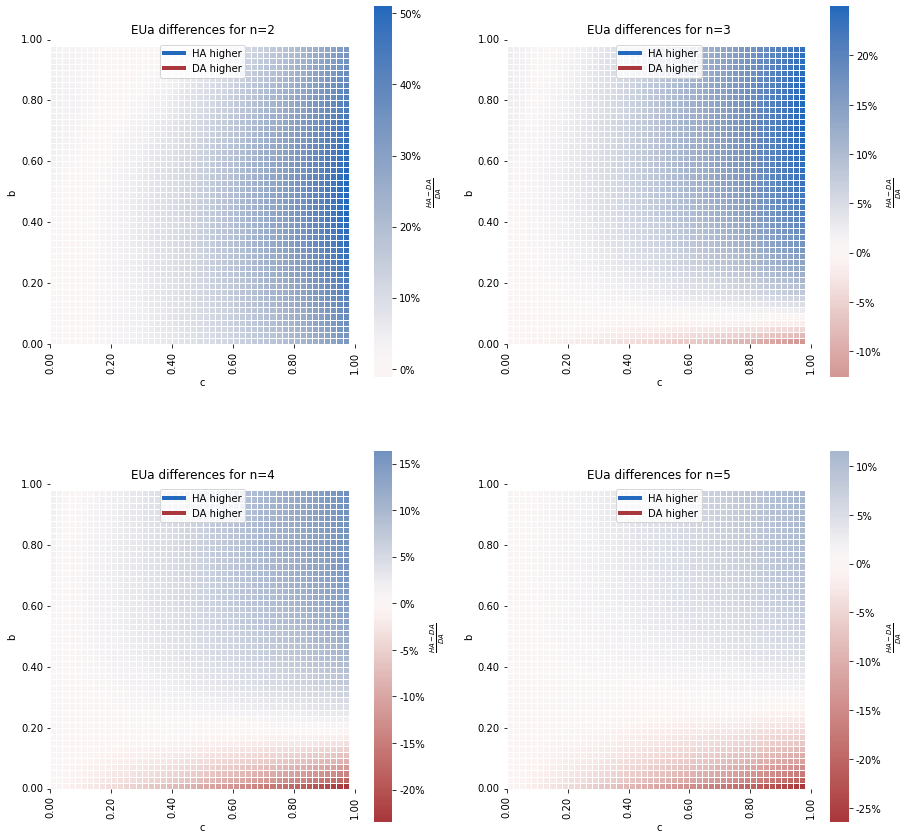

In [61]:
plt.figure(figsize=(15, 15))
type = "EUa"
plt.subplot(2, 2, 1)
graphPctHeatmap(2, 50, 0.02, type)
plt.subplot(2, 2, 2)
graphPctHeatmap(3, 50, 0.02, type)
plt.subplot(2, 2, 3)
graphPctHeatmap(4, 50, 0.02, type)
plt.subplot(2, 2, 4)
graphPctHeatmap(5, 50, 0.02, type)

<AxesSubplot:>

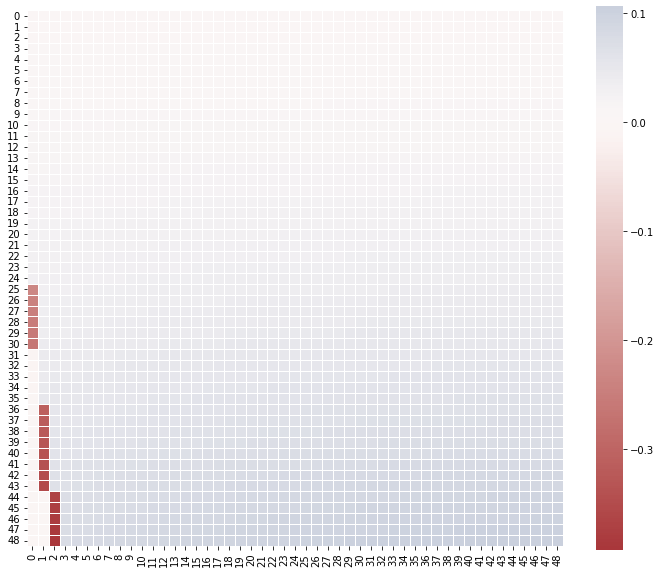

In [17]:
n1 = 4
n2 = 5
type = "EUb"

# ha1_list = pd.read_csv(str(n1) + "_ha_" + type + ".csv", header=None).values[1:50, 1:50]
# ha2_list = pd.read_csv(str(n2) + "_ha_" + type + ".csv", header=None).values[1:50, 1:50]
# diff_list = (ha1_list - ha2_list) / ha2_list

# da1_list = pd.read_csv(str(n1) + "_da_" + type + ".csv", header=None).values[1:50, 1:50]
# da2_list = pd.read_csv(str(n2) + "_da_" + type + ".csv", header=None).values[1:50, 1:50]
# diff_list = (da1_list - da2_list) / da2_list

ha1_list = pd.read_csv(str(n1) + "_ha_" + type + ".csv", header=None).values[1:50, 1:50]
da1_list = pd.read_csv(str(n1) + "_da_" + type + ".csv", header=None).values[1:50, 1:50]
diff1_list = (ha1_list - da1_list) / da1_list
ha2_list = pd.read_csv(str(n2) + "_ha_" + type + ".csv", header=None).values[1:50, 1:50]
da2_list = pd.read_csv(str(n2) + "_da_" + type + ".csv", header=None).values[1:50, 1:50]
diff2_list = (ha2_list - da2_list) / da2_list
diff_list = diff1_list - diff2_list

plt.figure(figsize=(12, 10), facecolor="white")
sns.heatmap(diff_list, center=0, cmap=sns.color_palette("vlag_r", as_cmap=True), square=True, linewidths=0.5,)

# Jumps in the optimal starting price $s$

Text(0.5, 0.98, 'Expected utility for the auctioneer \n (2 bidders, auctioneer cost of time c=0.10)')

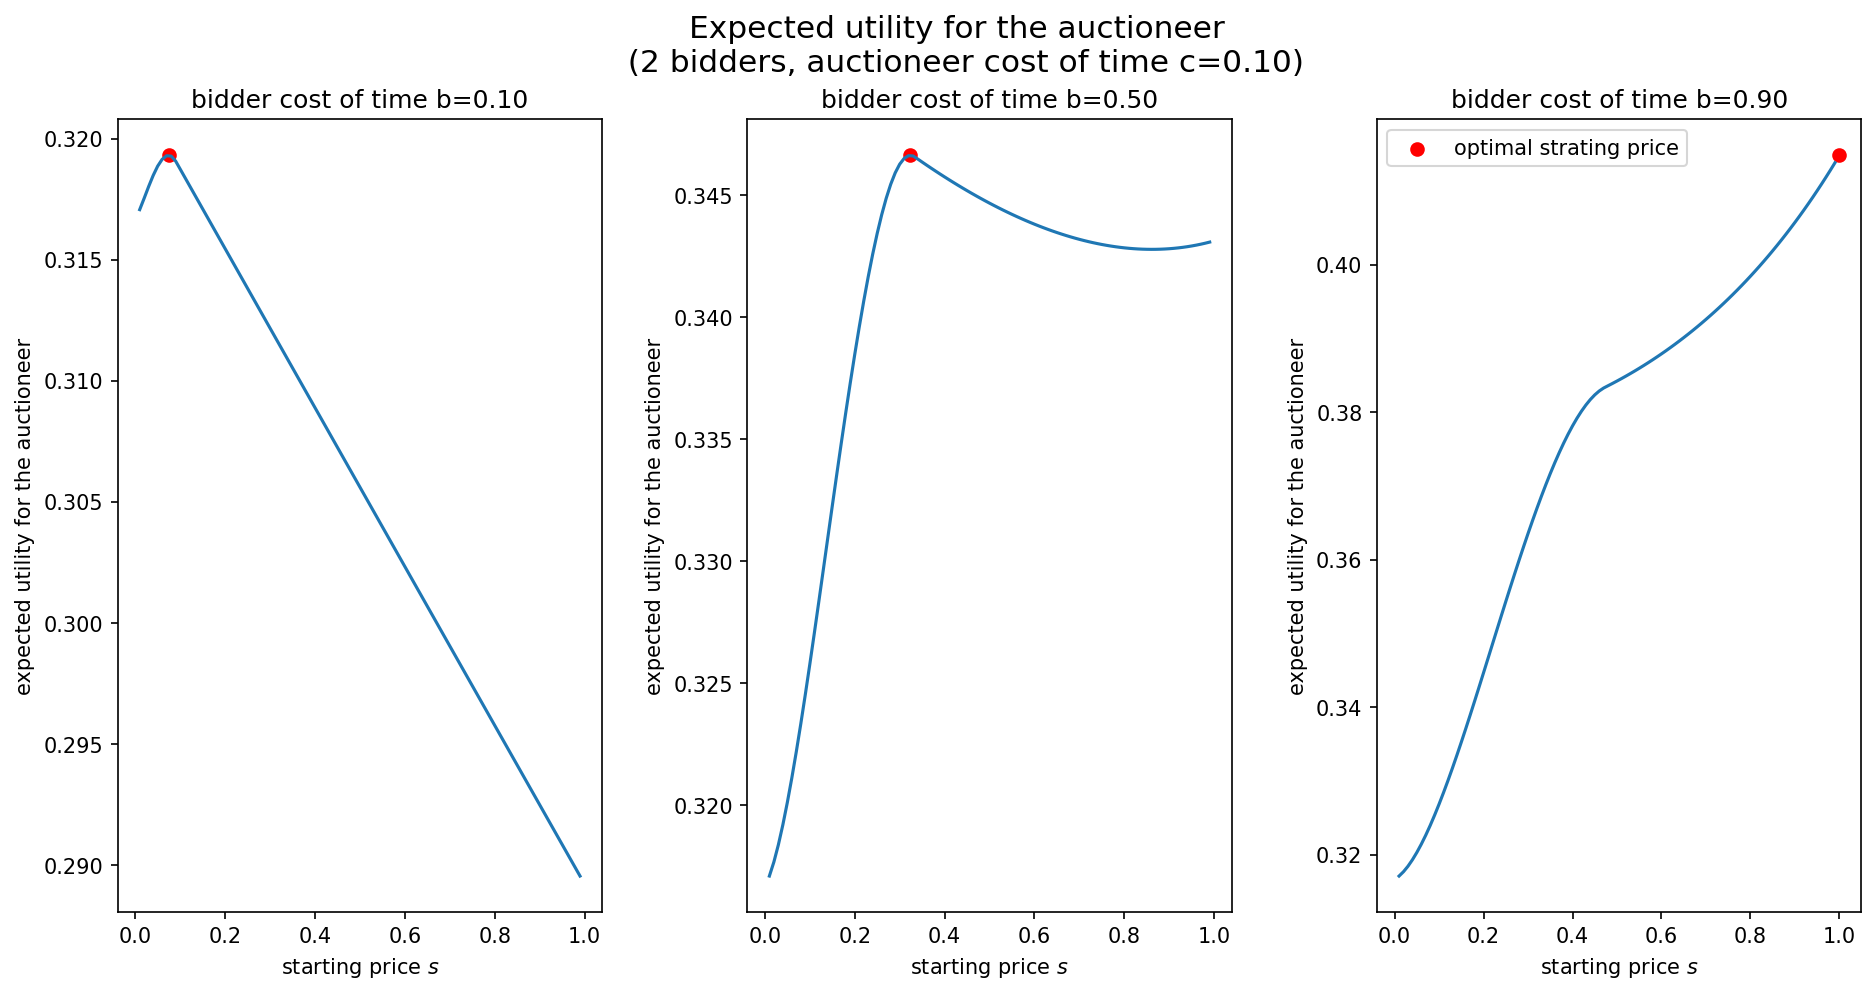

In [117]:
plt.figure(figsize=(15,7), dpi=150)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
list_s = np.arange(0.01, 1, 0.01)
c = 0.1
for i in [1, 2, 3]:
    list_u = []
    b = i * 0.4 - 0.3
    ha = honolulu(1, b, c, 2)
    for si in list_s:
        list_u.append(ha.U(si))
    plt.subplot(1, 3, i)
    plt.plot(list_s, list_u)
    plt.scatter(ha.s, ha.U(ha.s), color="red", label="optimal strating price")
    plt.xlabel(r"starting price $s$")
    plt.ylabel("expected utility for the auctioneer")
    plt.title("bidder cost of time b=%.2f" % b)
plt.legend()
plt.suptitle("Expected utility for the auctioneer \n (2 bidders, auctioneer cost of time c=%.2f)" % c, size=15)